# Modules to download

In [6]:
# !pip install antspyx
# !pip install SimpleITK
# !pip install helpers
# !pip install antspyx antspynet

In [19]:
# Importation for modules.
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, convex_hull_image
from skimage.segmentation import active_contour
from skimage.filters import gaussian
import ants
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import SimpleITK as sitk
from helpers import *
from antspynet.utilities import brain_extraction

In [31]:
# Function to display arrays
from ipywidgets import interact
def explore_3D_array(arr: np.ndarray, cmap: str='gray'):
    def fn(SLICE):
        plt.figure(figsize=(7,7))
        plt.axis('off')
        plt.imshow(arr[SLICE,:,:], cmap=cmap)

    interact(fn, SLICE=(0, arr.shape[0]-1))

def add_suffix_to_filename(filename: str, suffix: str) ->str:
    if filename.endswith('.nifti.hdr'):
        result = filename.replace('.nifti.hdr', f'_{suffix}.nifti.hdr')
        return result
    else:
        raise RuntimeError('filename with unknown ext')

def rescale_linear(array: np.ndarray, new_min: int, new_max: int):
  minimum, maximum = np.min(array), np.max(array)
  m = (new_max - new_min) / (maximum - minimum)
  b = new_min - m * minimum
  return m * array + b

def explore_3D_array_with_mask_contour(arr: np.ndarray, mask: np.ndarray, thickness: int = 1):
  _arr = rescale_linear(arr,0,1)
  _mask = rescale_linear(mask,0,1)
  _mask = _mask.astype(np.uint8)

  def fn(SLICE):
    arr_rgb = cv2.cvtColor(_arr[SLICE, :, :], cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(_mask[SLICE, :, :], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    arr_with_contours = cv2.drawContours(arr_rgb, contours, -1, (0,1,0), thickness)

    plt.figure(figsize=(7,7))
    plt.imshow(arr_with_contours)

  interact(fn, SLICE=(0, arr.shape[0]-1))

# Change this cell according to your directory

interactive(children=(IntSlider(value=63, description='SLICE', max=127), Output()), _dom_classes=('widget-inte…

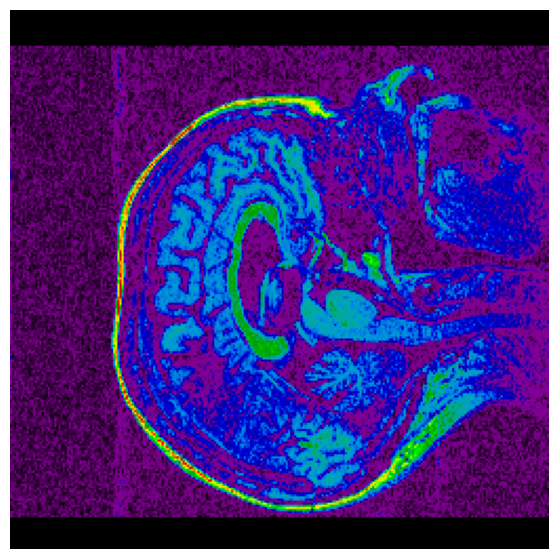

In [32]:
img_path = "/content/mpr-2.nifti.hdr"
ant_img = ants.image_read(img_path, reorient='RAS')
explore_3D_array(arr=ant_img.numpy(), cmap='nipy_spectral')

In [33]:
prob_brain_mask = brain_extraction(ant_img, modality="t1", verbose=True)

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
Brain extraction:  renormalize probability mask to native space.


In [34]:
brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)

interactive(children=(IntSlider(value=63, description='SLICE', max=127), Output()), _dom_classes=('widget-inte…

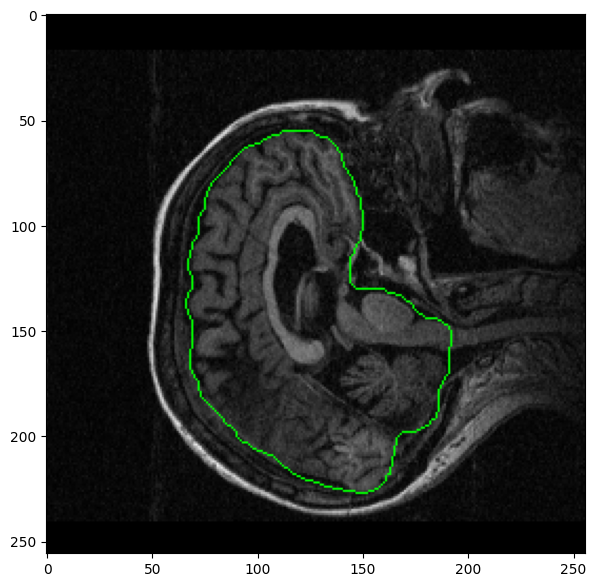

In [35]:
explore_3D_array_with_mask_contour(ant_img.numpy(), brain_mask.numpy())

interactive(children=(IntSlider(value=63, description='SLICE', max=127), Output()), _dom_classes=('widget-inte…

(128, 256, 256)

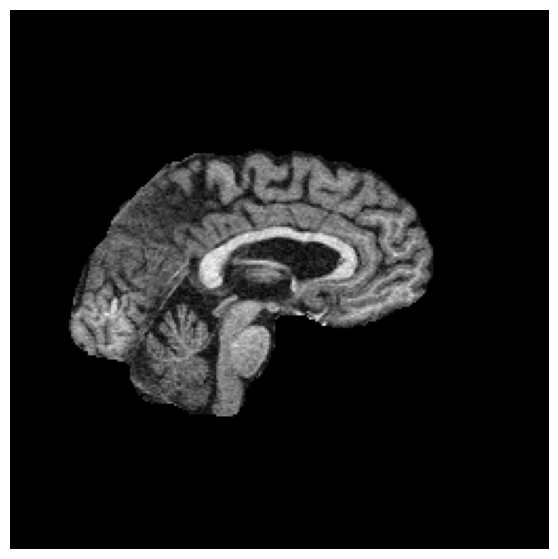

In [ ]:
# Apply the mask
masked = ants.mask_image(ant_img, brain_mask)

# Convert to NumPy array
masked_array = masked.numpy()

# Rotate by -90 degrees (or 90 degrees clockwise)
final_mask = np.rot90(masked_array, k=-1, axes=(1, 2))  # Adjust axes if needed

# Convert back to ANTs image (to preserve metadata)
rotated_masked_ant = ants.from_numpy(final_mask, origin=masked.origin, spacing=masked.spacing, direction=masked.direction)

# Visualize the rotated image
explore_3D_array(final_mask, cmap='gray')
final_mask.shape


In [ ]:
def preprocess_mri_image(img_array):
    """
    Preprocess an MRI image with the following steps:
    1. Convert to grayscale (if needed)
    2. Apply CLAHE for contrast enhancement
    3. Apply Gaussian blur
    4. Apply Median blur for noise reduction
    5. Apply sharpening
    6. Apply Non-Local Means Denoising
    7. Add salt-and-pepper noise at the end

    :param img_array: NumPy array of the MRI image
    :return: Processed NumPy array
    """

    if len(img_array.shape) == 3:  # Check if it's a 3D array (e.g., 128, 256, 256)
        processed_slices = []
        for i in range(img_array.shape[0]):  # Iterate through each slice
            slice_img = img_array[i]
            processed_slices.append(process_single_slice(slice_img))
        return np.array(processed_slices)

    else:
        return process_single_slice(img_array)

def process_single_slice(slice_img):
    """
    Process a single 2D slice of the MRI image.
    """
    # Ensure image is single-channel grayscale
    if len(slice_img.shape) == 3 and slice_img.shape[-1] == 3:  # Check if RGB
        slice_img = cv2.cvtColor(slice_img, cv2.COLOR_BGR2GRAY)

    # Normalize and convert to uint8
    slice_img = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply CLAHE (Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    slice_img = clahe.apply(slice_img)

    # Apply Gaussian Blur
    slice_img = cv2.GaussianBlur(slice_img, (5, 5), 0)

    # Apply Median Blur
    slice_img = cv2.medianBlur(slice_img, 5)

    # Apply sharpening filter
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    slice_img = cv2.filter2D(slice_img, -1, sharpen_kernel)

    # Apply Non-Local Means Denoising
    slice_img = cv2.fastNlMeansDenoising(slice_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Add Salt-and-Pepper Noise
    slice_img = add_salt_and_pepper(slice_img)

    return slice_img

def add_salt_and_pepper(img, salt_prob=0.02, pepper_prob=0.02):
    """
    Function to add salt-and-pepper noise to an image.
    """
    noisy_img = img.copy()
    num_salt = int(salt_prob * img.size)
    num_pepper = int(pepper_prob * img.size)

    # Add salt (white pixels)
    coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy_img[tuple(coords)] = 255

    # Add pepper (black pixels)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy_img[tuple(coords)] = 0

    return noisy_img

interactive(children=(IntSlider(value=63, description='SLICE', max=127), Output()), _dom_classes=('widget-inte…

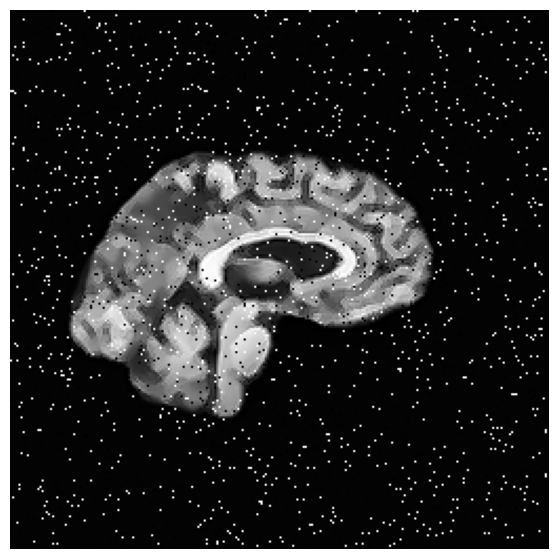

In [59]:
# Assuming final_mask is a 3D array with shape (128, 256, 256)
processed_img = preprocess_mri_image(final_mask)
explore_3D_array(processed_img)